In [1]:
import dv_processing as dv
import torch
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader_refac import ModelLoader
from snn_delays.utils.train_utils_refact_minimal import get_device
from snn_delays.utils.hw_aware_utils import quantize_weights
from snn_delays.utils.hw_aware_utils import save_weights_delays, save_state
import numpy as np
import os
device = get_device() 

# For reproducibility
torch.manual_seed(10)

Running on: cuda:0


In [2]:
add_name = '_q8'

# ckpt_dir = 'abcxo' # 250, 1e6
# model = 'abcxo_f_9233333333333333' #45x45

# ckpt_dir = 'abcxo_32' # 250, 1e6
# model = 'abcxo_f_9916666666666667' #32x32

# ckpt_dir = 'abcxo_32_24' # 250, 1e6
# model = 'abcxo_f_9783333333333333'

ckpt_dir = 'abcxo_32_24_1ms' # 250, 1e6
model = 'abcxo_f_9916666666666667_1ms'

In [7]:
dataset = 'davis'
#total_time = 50
total_time = 250
batch_size = 64
folder_name = 'ABCXO'
size = 32 # or 45

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = size,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

snn = ModelLoader(model, ckpt_dir, batch_size, device) 

[CenterCrop(sensor_size=(240, 180, 2), size=(180, 180)), Downsample(time_factor=1, spatial_factor=0.17777777777777778, sensor_size=None, target_size=None), ToFrame(sensor_size=(32, 32, 2), time_window=None, event_count=None, n_time_bins=250, n_event_bins=None, overlap=0, include_incomplete=False)]
Delta t: 1.0 ms
Delta t: 1.0 ms
Delta t: 1.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [8]:
# snn.input2spike_th = 0.5
_, __ = snn.test(test_loader)

600
Test Loss: 0.020068619586527347
Avg spk_count per neuron for all 250 time-steps 1626.8991666666666
Test Accuracy of the model on the test samples: 99.167



In [9]:
weight_params_names = [name for name, param in snn.named_parameters() if 'linear' in name]

In [10]:
weight_params_names

['layers.0.linear.weight', 'layers.1.linear.weight', 'layers.2.linear.weight']

In [11]:
def getattr_dotted(obj, attr_str):
    for attr in attr_str.split('.'):
        obj = getattr(obj, attr)
    return obj
getattr_dotted(snn, weight_params_names[0])

Parameter containing:
tensor([[ 0.0331,  0.0207,  0.0469,  ..., -0.0079, -0.0011, -0.0189],
        [ 0.0152,  0.0225,  0.0264,  ...,  0.0058, -0.0118, -0.0323],
        [ 0.0110, -0.0089,  0.0222,  ...,  0.0069,  0.0196,  0.0244],
        ...,
        [ 0.0254,  0.0212,  0.0080,  ...,  0.0065, -0.0136, -0.0001],
        [-0.0187,  0.0206,  0.0074,  ...,  0.0166, -0.0123, -0.0105],
        [ 0.0153,  0.0083,  0.0165,  ..., -0.0168,  0.0144,  0.0143]],
       device='cuda:0', requires_grad=True)

### Weight quantization

In [12]:
quantize_weights(snn, 8, last_layer=True, symmetry=True, print_info=True)
_, __ = snn.test(test_loader)

----layers.0.linear.weight----
n_unique before quantization: 49139, 26902 pos 22237 neg
max_value before quantization: 0.12184841930866241
n_unique after quantization: 218, 111 pos 106 neg
max_value after quantization: 0.12089648097753525, delta_w: 0.0009519407758489251
----layers.1.linear.weight----
n_unique before quantization: 576, 287 pos 289 neg
max_value before quantization: 0.43425169587135315
n_unique after quantization: 177, 85 pos 91 neg
max_value after quantization: 0.43085911870002747, delta_w: 0.0033925913739949465
----layers.2.linear.weight----
n_unique before quantization: 120, 58 pos 62 neg
max_value before quantization: 0.64223712682724
n_unique after quantization: 89, 41 pos 47 neg
max_value after quantization: 0.6372196674346924, delta_w: 0.01505243219435215
600
Test Loss: 0.01919847009703517
Avg spk_count per neuron for all 250 time-steps 1626.8991666666666
Test Accuracy of the model on the test samples: 99.167



<AxesSubplot:>

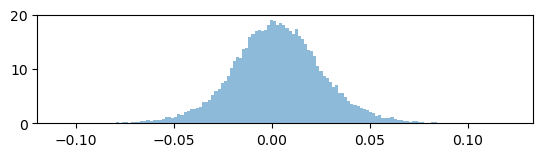

In [13]:
import matplotlib.pyplot as plt
from snn_delays.utils.visualization_utils import plot_param
plt.subplot(311)
plot_param(snn.layers[0].linear, 'histogram_nonzero')
# plt.subplot(312)
# plot_param(snn.f1_o, 'histogram_nonzero')
# plt.subplot(313)
# plot_param(snn.f2_o, 'histogram_nonzero')

### Save weights, delays, spikes and mems

In [14]:
ckpt_dir_2 = 'weights_' + model + add_name
save_path = os.path.join(
    os.environ.get('SNN_CHECKPOINTS_PATH'), ckpt_dir, ckpt_dir_2)

save_weights_delays(snn, path=save_path)

no delays in this network. setting all delays to zero.
no delays in this network. setting all delays to zero.
no delays in this network. setting all delays to zero.
Weights and delays saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_32_24_1ms\weights_abcxo_f_9916666666666667_1ms_q8
